In [20]:
from numdifftools import Gradient
import numdifftools as ndt
import math
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import random

In [21]:
def vector_mod(x: list):
    return math.sqrt(sum([i ** 2 for i in x]))


def lists_sub(a: list, b: list):
    if len(a) != len(b):
        raise ArithmeticError("Lists must be same length")
    return [a[i] - b[i] for i in range(len(a))]


def lists_sum(a: list, b: list):
    if len(a) != len(b):
        raise ArithmeticError("Lists must be same length")
    return [a[i] + b[i] for i in range(len(a))]


def multiply_list(a: list, x):
    return [i * x for i in a]


In [22]:
class Method:
    def __init__(self, func, eps, n, _lambda, x0: list):
        self.func = func
        self.eps = eps
        self.x0 = x0
        self.n = n
        self._lambda = _lambda
        self.iterations = 0
        self.function_calls = 0
        self.answer = None
        self.answer_point = None
        self.relations = []
        self.range = []
        self.segments = []

    def run(self):
        raise NotImplementedError()

    @classmethod
    def len_vector(cls, x: list):
        return sum([i ** 2 for i in x]) ** 0.5

    def calculate_gradient(self, x: list):
        return Gradient(self.func)(x)

    def lambda_static(self):
        return self._lambda

    def lambda_by_golden_section(self, x: list):
        a = 0
        b = 10
        gr = self.calculate_gradient(x)

        k1 = (3 - math.sqrt(5)) / 2
        k2 = (math.sqrt(5) - 1) / 2

        p1 = a + k1 * (b - a)
        p2 = a + k2 * (b - a)

        f1 = self.func([x[i] - gr[i] * p1 for i in range(len(gr))])
        f2 = self.func([x[i] - gr[i] * p2 for i in range(len(gr))])
        while True:
            if f1 < f2:
                b = p2
                p2 = p1
                f2 = f1
                p1 = a + k1 * (b - a)
                f1 = self.func([x[i] - gr[i] * p1 for i in range(len(gr))])
            else:
                a = p1
                p1 = p2
                f1 = f2
                p2 = a + k2 * (b - a)
                f2 = self.func([x[i] - gr[i] * p2 for i in range(len(gr))])
            if b - a < self.eps:
                return (a + b) / 2

    def lambda_by_fibonacci(self, x: list):
        a = 0
        b = 1

        def fib(x):
            return int(1 / math.sqrt(5) * (((1 + math.sqrt(5)) / 2) ** x - ((1 - math.sqrt(5)) / 2) ** x))

        fn_2 = (b - a) / self.eps
        n = 1
        while fib(n) <= fn_2:
            n += 1
        n -= 2

        gr = self.calculate_gradient(x)

        p1 = a + fib(n) / fib(n + 2) * (b - a)
        p2 = a + fib(n + 1) / fib(n + 2) * (b - a)

        f1 = self.func([x[i] - gr[i] * p1 for i in range(len(gr))])
        f2 = self.func([x[i] - gr[i] * p2 for i in range(len(gr))])

        k = 0
        while k < n:
            k += 1
            if f1 <= f2:
                b = p2
                p2 = p1
                p1 = b + a - p2
                f2 = f1
                f1 = self.func([x[i] - gr[i] * p1 for i in range(len(gr))])
            else:
                a = p1
                p1 = p2
                p2 = b + a - p1
                f1 = f2
                f2 = self.func([x[i] - gr[i] * p2 for i in range(len(gr))])
        return (a + b) / 2

    def lambda_by_half_interval (self, x: list):
        a = 0
        b = 10
        gr = self.calculate_gradient(x)
        delta = (self.eps / 2) * 0.9

        while abs(b - a) > self.eps:
            p1 = (a + b) / 2 - delta
            p2 = (a + b) / 2 + delta
            f1 = self.func([x[i] - gr[i] * p1 for i in range(len(gr))])
            f2 = self.func([x[i] - gr[i] * p2 for i in range(len(gr))])
            if f1 > f2:
                a = p1
            else:
                b = p2

In [23]:
def it_plot(its: list, n):
    x = [i for i in range(1, 200)]
    plt.plot(x, its)
    plt.show()


def plot_and_show(m: Method):
    x = np.mgrid[-20:20:150j, -20:20:150j]

    # z = x[0]**2 + 2 * x[1]**2 + 3
    z = 2 * x[0]**2 + 4 * x[1]**2 - 1 * x[0] * x[1] - 5 * x[0]

    fig, ax = plt.subplots()
    cp = ax.contour(x[0], x[1], z, levels=50)

    for p in m.segments:
        x = [p[0][0], p[1][0]]
        y = [p[0][1], p[1][1]]
        ax.plot(x, y, color='blue')

    plt.show()

In [24]:
class GradientConst(Method):
    def iteration(self, x0):
        gradx0 = self.calculate_gradient(x0)
        _lambda = self.lambda_static()

        s = _lambda * gradx0
        x = lists_sub(x0, s)
        self.iterations += 1
        return x, s

    def run(self):
        x0 = self.x0
        x, s = self.iteration(x0)

        while vector_mod(s) >= self.eps:
            self.segments.append([x0, x])
            x0 = x
            x, s = self.iteration(x0)
            print(vector_mod(lists_sub(x0, x)), self.iterations)
        pre_result = lists_sum(x, x0)
        self.answer = self.func(multiply_list(pre_result, 1 / 2))
        self.answer_point = multiply_list(pre_result, 1 / 2)


In [25]:
class GradientFastest(Method):
    def run(self):
        x0 = self.x0
        gradx0 = self.calculate_gradient(x0)
        _lambda = self.lambda_by_fibonacci(x0)

        s = _lambda * gradx0
        x = lists_sub(x0, s)
        self.iterations += 1

        while vector_mod(s) >= self.eps:
            # self.segments.append([x0, x])
            x0 = x
            gradx0 = self.calculate_gradient(x0)
            _lambda = self.lambda_by_fibonacci(x0)
            s = _lambda * gradx0
            x = lists_sub(x0, s)
            self.iterations += 1
        pre_result = lists_sum(x, x0)
        self.answer = self.func(multiply_list(pre_result, 1 / 2))
        self.answer_point = multiply_list(pre_result, 1 / 2)

In [26]:
class ConjugateDir(Method):
    def run(self):
        p = [[1, 0], [0, 1]]
        cur_x = self.x0[:]
        prev_x = cur_x[:]
        while self.len_vector(p[1]) >= self.eps:
            new_function = lambda l: self.func([cur_x[k] + l * p[1][k] for k in range(len(cur_x))])
            h_min = optimize.minimize(new_function, x0=0)["x"][0]
            cur_x = [cur_x[k] + h_min * p[1][k] for k in range(len(cur_x))]
            self.segments.append([prev_x, cur_x])
            prev_x = cur_x[:]
            y = cur_x[:]
            i = 0
            while i <= 1:
                new_function = lambda l: self.func([cur_x[k] + l * p[i][k] for k in range(len(cur_x))])
                h_min = optimize.minimize(new_function, x0=0)["x"][0]
                cur_x = [cur_x[k] + h_min * p[i][k] for k in range(len(cur_x))]
                i += 1
            i = 0
            self.iterations += 1
            p[i] = p[i+1][:]
            p[1] = [cur_x[k] - y[k] for k in range(len(p))]
        self.answer_point = cur_x


In [27]:
class Newton(Method):
    def run(self):
        x0 = self.x0[:]
        gradient = self.calculate_gradient(x0)
        hessian = ndt.Hessian(self.func)(x0)
        print(gradient)
        print(hessian)
        s = np.linalg.solve(hessian, [-i for i in gradient])
        x = lists_sum(x0, s)

        while vector_mod(s) >= self.eps:
            self.segments.append([x0, x])
            x0 = x
            gradient = self.calculate_gradient(x0)
            hessian = ndt.Hessian(self.func)(x0)
            s = np.linalg.solve(hessian, [-i for i in gradient])
            x = lists_sum(x0, s)
            self.iterations += 1

        self.answer_point = x
        self.answer = self.func(x)


In [28]:
def draw_lines(f: (), x, y, lines):
    x = np.linspace(x[0], x[1], math.ceil(20*(x[1] - x[0])))
    y = np.linspace(y[0], y[1], math.ceil(20*(y[1] - y[0])))

    X, Y = np.meshgrid(x, y)
    Z = [[f((X[i][j], Y[i][j])) for j in range(x.size)] for i in range(y.size)]
    plt.contour(X, Y, Z)
    for i in range(len(lines) - 1):
        plt.plot([-lines[i][0], -lines[i + 1][0]], [-lines[i][1], -lines[i + 1][1]])
    plt.show()


In [29]:
def fletcher_reeves(x0, e, f: (), find__min_f: (), bounds):
    path = []
    x_cur = np.array(x0)
    path.append(x_cur)
    n = len(x0)
    k = 0
    grad = optimize.approx_fprime(x_cur, f, e ** 4)
    prev_grad = 1
    p_k = -1 * grad
    while np.linalg.norm(grad) > e:
        if k % n == 0:
            p_k = -1 * grad
        else:
            b_k = (np.linalg.norm(grad) ** 2) / (np.linalg.norm(prev_grad) ** 2)
            prev_pk = p_k
            p_k = -1 * grad + b_k * prev_pk
        a = find__min_f(bounds[0], bounds[1], e, lambda x: f(x_cur + p_k * x))[0]
        x_cur = x_cur + a * p_k
        path.append(x_cur)
        k += 1
        prev_grad = grad
        grad = optimize.approx_fprime(x_cur, f, e ** 4)
    return x_cur, f(x_cur), len(path), path


In [30]:
class ConjugateGrad(Method):
    def run(self):
        k = 0
        pk = ndt.Gradient(self.func)(self.x0)
        cur_x = self.x0[:]
        prev_x = cur_x[:]

        while True:
            tmp = cur_x[:]
            cur_x = [cur_x[i] - self.lambda_by_golden_section(self.x0)*pk[i] for i in range(len(cur_x))]
            self.segments.append([prev_x, cur_x])
            prev_x = cur_x[:]
            gr = ndt.Gradient(self.func)(cur_x)

            if self.len_vector(gr) < self.eps:
                break

            if k + 1 == self.n:
                self.x0 = cur_x[:]
                k = 0
                pk = ndt.Gradient(self.func)(self.x0)
                continue

            b = ((self.len_vector(ndt.Gradient(self.func)(cur_x)) ** 2) /
                 (self.len_vector(ndt.Gradient(self.func)(tmp)) ** 2))
            pk = [-gr[i] - b*pk[i] for i in range(len(pk))]
            self.iterations += 1
        self.answer = cur_x
        self.answer_point = self.func(cur_x)
        return self.answer


In [31]:
def powell_method(x0, e, f: (), find__min_f: (), bounds):
    path = []
    x_cur = np.array(x0)
    x_prev = x_cur
    t_vec = [x_cur]
    path.append(x_cur)
    n = len(x0)
    k, i = 0, 0
    d_vec = np.eye(n).tolist()
    d_vec.append(d_vec[0])
    d_vec = np.array(d_vec)
    while True:
        a = find__min_f(bounds[0], bounds[1], e, lambda x: f(t_vec[i] + d_vec[i] * x))[0]
        t_vec.append(t_vec[i] + d_vec[i] * a)
        if i == n - 1:
            if np.linalg.norm(t_vec[0] - t_vec[n]) < e:
                x_cur = t_vec[n]
                path.append(x_cur)
                return x_cur, f(x_cur), path
            i += 1
        elif i == n:
            x_cur = t_vec[n + 1]
            path.append(x_cur)
            if np.linalg.norm(t_vec[1] - t_vec[n + 1]) < e:
                return x_cur, f(x_cur), len(path), path
            else:
                if np.linalg.norm(x_cur - x_prev) < e:
                    return x_cur, f(x_cur), len(path), path
                k += 1
                i = 0
                rank = np.linalg.matrix_rank(d_vec)
                if rank == n:
                    d_vec[0] = d_vec[n] = t_vec[n + 1] - t_vec[1]
                    for k in range(1, n - 1):
                        d_vec[k] = d_vec[k + 1]
                t_vec.clear()
                t_vec.append(x_cur)
        else:
            i += 1

In [32]:
def fibonacci_method(left: float, right: float, length: float, func: ()):
    eps = 0.01
    fibonacci_list = [1, 1]
    func_count = 0
    length_values = [right - left]
    index = 1
    while fibonacci_list[index] < (right - left) / length:
        index += 1
        fibonacci_list.append(fibonacci_list[index - 1] + fibonacci_list[index - 2])

    n = len(fibonacci_list) - 1
    lambda_ = left + fibonacci_list[n - 2] / fibonacci_list[n] * (right - left)
    mu_ = left + fibonacci_list[n - 1] / fibonacci_list[n] * (right - left)

    f_lambda = func(lambda_)
    f_mu = func(mu_)
    func_count += 2

    for k in range(1, n):
        if f_lambda > f_mu:
            left = lambda_
            lambda_ = mu_
            f_lambda = f_mu
            if k == n - 2:
                mu_ = left + (0.5 + eps) * (right - left)
            else:
                mu_ = left + fibonacci_list[n - k] / fibonacci_list[n - k + 1] * (right - left)
            f_mu = func(mu_)
            func_count += 1
        else:
            right = mu_
            mu_ = lambda_
            f_mu = f_lambda
            if k == n - 2:
                lambda_ = left + (0.5 - eps) * (right - left)
            else:
                lambda_ = left + fibonacci_list[n - k - 1] / fibonacci_list[n - k + 1] * (right - left)
            f_lambda = func(lambda_)
            func_count += 1
        length_values.append(right - left)

    return (right + left) / 2, func((right + left) / 2), n, func_count + 1, length_values


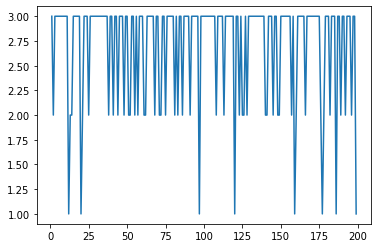

segments:  []
answer:  0.0
answer point:  [0.0, 1.0, 5.0, 3.0, 8.0, -5.0, -4.0, -3.0, -1.0, 1.0, 0.0, -4.0, -3.0, 10.0, 7.0, 7.0, 8.0, 3.0, -5.0, -10.0, -7.0, -3.0, -2.0, 3.0, 7.0, 1.0, 2.0, 8.0, -10.0, -3.0, -5.0, 5.0, 6.0, 0.0, 0.0, 5.0, -9.0, -7.0, -5.0, -4.0, 10.0, 7.0, -2.0, -9.0, 6.0, -9.0, 8.0, 0.0, -4.0, 3.0, -9.0, 1.0, -5.0, 9.0, -4.0, 6.0, -1.0, 4.0, 3.0, -1.0, 0.0, -2.0, 3.0, -6.0, 5.0, -4.0, -4.0, 8.0, -5.0, 6.0, 6.0, 3.0, 4.0, -9.0, 5.0, 4.0, 1.0, 6.0, -4.0, -1.0, -8.0, 0.0, -8.0, -3.0, 0.0, 8.0, 6.0, -7.0, -10.0, -4.0, 6.0, -1.0, -10.0, 9.0, -10.0, 0.0, 1.0, -4.0, -3.0, -4.0]


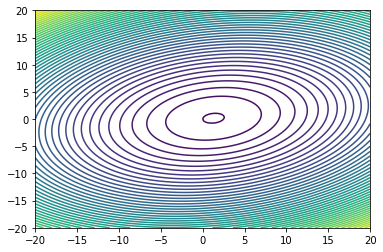

In [33]:
def generate_func(k: int, n: int):
    a = [1]
    for i in range(n - 2):
        a.append(random.randint(1, k))
    a.append(k)
    # print(a)

    def funct(x: list):
        for i in range(n):
            return x[i]**2 * a[i]
    return funct


def func(x: list) -> float:
    # return x[0]**2 + x[1]**2 + 3  # [12, -3]
    # return 2 * x[0]**2 + 4 * x[1]**2 - 1 * x[0] * x[1] - 5 * x[0]  # [-3, 5]
    # return -3 * x[0]**2 + x[1]**2 + 7 * x[0] * x[1] - 3 * x[1] + 9  # [12, 9]
    # ans = 100 * x[0] + x[1]
    return (1 - x[0])**2 + 100 * ((x[1] - x[0]**2) ** 2)
    # return ans
    # pass

n = 100
iterations = []
for k in range(1, 200):
    f = generate_func(k, n)
    rand_point = [random.randint(-10, 10) for i in range(n)]
    method = GradientFastest(f, 0.001, n, 0.5, rand_point)
    method.run()
    iterations.append(method.iterations)
    # print('steps: ', method.iterations)

it_plot(iterations, n)
print("segments: ", method.segments)
print("answer: ", method.answer)
print("answer point: ", method.answer_point)
plot_and_show(method)


(array([-0.00401481,  0.00866524]), 7.253445179957164e-05, 4, [array([-4, -4]), array([ 0.57359371, -1.25584349]), array([0.03243017, 0.02963803]), array([-0.00401481,  0.00866524])])


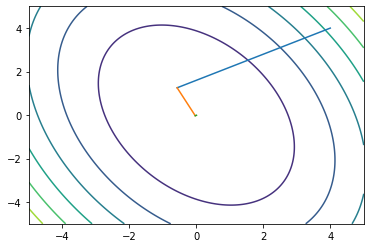

(array([0.0064189 , 0.02106483]), 0.0006613447566682502, 3, [array([-4, -4]), array([ 0.1319989 , -0.50362073]), array([0.0064189 , 0.02106483])])


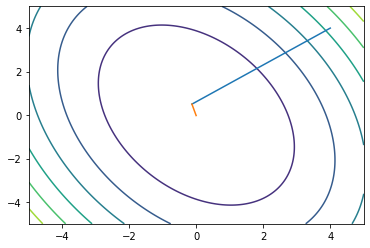

In [34]:
def f1(vec):
    x, y = vec
    return 4 * pow((x - 5), 2) + pow((y - 6), 2)


def f2(vec):
    x, y = vec
    return 2 * x ** 2 + x * y + y ** 2


def f3(x):
    x1, x2, x3, x4 = x
    return ((x1 + 10 * x2) ** 2 +
            5 * (x3 - x4) ** 2 +
            (x2 - 2 * x3) ** 4 +
            10 * (x1 - x4) ** 4)


if __name__ == '__main__':
    x0 = (-4, -4)
    eps = 0.05
    bounds = (-100, 100)
    vis_bounds = (-5, 5)
    f = f2
    res1 = (fletcher_reeves(x0=x0, e=eps, f=f, find__min_f=fibonacci_method, bounds=bounds))
    print(res1)
    draw_lines(f, vis_bounds, vis_bounds, res1[3])
    res2 = (powell_method(x0=x0, e=eps, f=f, find__min_f=fibonacci_method, bounds=bounds))
    print(res2)
    draw_lines(f, vis_bounds, vis_bounds, res2[3])
